# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, learning_curve,\
train_test_split, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_recall_curve
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, SGDClassifier, Ridge, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.compose import make_column_selector

## pipeline stuff

from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display='diagram')



import warnings 
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
import itertools

from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
import random
import os


import pickle
import catboost
from catboost import *
import shap
import joblib


# Random Seed all

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
seed_everything(42)

# Read parquets & preprocessing

## Read Train data 

In [ ]:
train_labels = pd.read_csv("/Users/sjoerddewit/Desktop/Programming/6 Le Wagon Data Science/final_project/train_labels.csv")
df = pd.read_parquet("/Users/sjoerddewit/Desktop/Programming/6 Le Wagon Data Science/final_project/train_data.parquet")


In [ ]:
df.shape , train_labels.shape

In [ ]:
df.head(2)

## Read Test data 

In [ ]:
test = pd.read_parquet("/Users/sjoerddewit/Downloads/test_data.parquet")


In [ ]:
df = df.repartition(partition_size="100MB")


In [ ]:
for col in test.columns:
    if test[col].dtype=='float16':
#         train[col] = train[col].astype('float32').round(decimals=2).astype('float16')
        test[col] = test[col].astype('float32').round(decimals=2).astype('float16')

In [ ]:
test.head(1)

In [ ]:
df = test.copy()

In [ ]:
test.shape, df.shape

In [ ]:
df['customer_ID'] = df['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')


In [ ]:
customer_ids = pd.DataFrame(test['customer_ID'])
customer_ids['customer_ID_reduced'] = df['customer_ID']

In [ ]:
# customer_ids.groupby('customer_ID', axis=0)

In [ ]:
customer_ids.shape

In [ ]:
customer_ids.shape

In [ ]:
df.head(15)

## Preprocessing

<b> ADD preprocess ISIS : <b>

In [ ]:
cat_vars = ['B_30',
#             'B_31',
            'B_38', 
            'D_114', 
            'D_116', 
            'D_117', 
            'D_120', 
            'D_126', 
            'D_63', 
            'D_64', 
            'D_66', 
            'D_68',
#             'D_87'
           ]



<b>-end- ADD preprocess ISIS<b>

In [ ]:
# ### Fancy features

# df["c_PD_239"]=df["D_39"]/(df["P_2"]*(-1)+0.0001)
# df["c_PB_29"]=df["P_2"]*(-1)/(df["B_9"]*(1)+0.0001)
# df["c_PR_21"]=df["P_2"]*(-1)/(df["R_1"]+0.0001)

# df["c_BBBB"]=(df["B_9"]+0.001)/(df["B_23"]+df["B_3"]+0.0001)
# df["c_BBBB1"]=(df["B_33"]*(-1))+(df["B_18"]*(-1)+df["S_25"]*(1)+0.0001)
# df["c_BBBB2"]=(df["B_19"]+df["B_20"]+df["B_4"]+0.0001)

# df["c_RRR0"]=(df["R_3"]+0.001)/(df["R_2"]+df["R_4"]+0.0001)
# df["c_RRR1"]=(df["D_62"]+0.001)/(df["D_112"]+df["R_27"]+0.0001)

# df["c_PD_348"]=df["D_48"]/(df["P_3"]+0.0001)
# df["c_PD_355"]=df["D_55"]/(df["P_3"]+0.0001)

# df["c_PD_439"]=df["D_39"]/(df["P_4"]+0.0001)
# df["c_PB_49"]=df["B_9"]/(df["P_4"]+0.0001)
# df["c_PR_41"]=df["R_1"]/(df["P_4"]+0.0001)

#  # compute "after pay" features
# for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
#     for pcol in ['P_2','P_3']:
#          if bcol in df.columns:
#                 df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]


In [ ]:
## get all feature names, except customer_ID and dates
features = df.drop(columns=[
    'customer_ID', 
    'S_2'
], axis = 1).columns.to_list() 

num_features = [feature for feature in features if feature not in cat_vars]


In [ ]:
num_features

In [ ]:
train_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'first', 'last', 'sum']) # give summary statistics for each numerical feature
train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns] # join the column name tuples to a single name
train_num_agg.reset_index(inplace = True) # get the customer_ID in as a column again and reset index


<b> ADD preprocess ISIS : <b>

In [ ]:
# for col in num_features:
#     train_num_agg[f'{col}_last_first_diff'] = train_num_agg[f'{col}_last'] - train_num_agg[f'{col}_first']
#     train_num_agg[f'{col}_last_first_div'] = train_num_agg[f'{col}_last'] / train_num_agg[f'{col}_first']

<b>-end- ADD preprocess ISIS<b>

In [ ]:
df.shape

In [ ]:
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    return df1

In [ ]:
train_diff = get_difference(df, num_features)



In [ ]:
## categorical feature aggregation
train_cat_agg = df.groupby("customer_ID")[cat_vars].agg(['count', 'last', 'nunique']) # give summary statistics for each categrocial feature


In [ ]:
train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns] # join the column name tuples to a single name


In [ ]:
train_cat_agg.reset_index(inplace = True) # get the customer_ID in as a column again and reset index




In [ ]:
df_agg = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')

# df_agg = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(target, how = 'inner', on = 'customer_ID')



In [ ]:
cat_features = [f"{cf}_last" for cf in cat_vars]
encoder = OrdinalEncoder()
df_agg[cat_features] = encoder.fit_transform(df_agg[cat_features])
num_cols_mean = [col for col in df_agg.columns if 'mean' in col]
num_cols_last = [col for col in df_agg.columns if 'last' in col and col not in cat_features]


for col in range(len(num_cols_last)):
    try:
        df_agg[f'{num_cols_last[col]}_mean_diff'] = df_agg[num_cols_last[col]] - df_agg[num_cols_mean[col]]
    except:
        pass


In [ ]:
cat_features

cat_features

 ['B_30_last',
 'B_31_last',
 'B_38_last',
 'D_114_last',
 'D_116_last',
 'D_117_last',
 'D_120_last',
 'D_126_last',
 'D_63_last',
 'D_64_last',
 'D_66_last',
 'D_68_last',
 'D_87_last']

<b> ADD preprocess ISIS : <b>

In [ ]:
# df_agg[cat_features] = df_agg[cat_features].fillna(-127).astype(int)

<b>-end- ADD preprocess ISIS<b>

In [ ]:
for cat in cat_features:
    if cat in df_agg.columns:
        print('True')
    else:
        print('False')

In [ ]:
del train_num_agg, train_cat_agg, train_diff
import gc
gc.collect()

In [ ]:
df_agg[cat_features]

## To parquet, read parquet

In [ ]:
df_agg.to_parquet('/Users/sjoerddewit/Desktop/Programming/6 Le Wagon Data Science/final_project/df_train_agg_complete.parquet')


In [ ]:
df_agg.shape #2109

In [ ]:
df_agg = pd.read_parquet("/Users/sjoerddewit/Desktop/Programming/6 Le Wagon Data Science/final_project/df_train_agg_complete.parquet")


In [ ]:
df_agg.shape #2109

# Amex metric

In [ ]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    ## TWEAK
    y_pred = pd.Series(y_pred, index=y_true.index)

    y_true = pd.DataFrame(y_true)
    y_pred = pd.DataFrame(y_pred)

    y_true = y_true.rename(columns={y_true.columns[0]:'target'})
    y_pred = y_pred.rename(columns={y_pred.columns[0]:'prediction'})
    ##

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)


In [ ]:
amex_metric_scorer = make_scorer(amex_metric)

## dict of scoring metrics one might want to pass into cross validation
scorings = {'recall':'recall',
            'f1':'f1',
           'amex': amex_metric_scorer}

print('done ✅')

# Modelling cat boost reloadeddddd

In [ ]:
import optuna
from sklearn.metrics import accuracy_score
import catboost as ctb
from catboost import Pool


from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold 
import xgboost as xgb
print('XGB Version',xgb.__version__)
print('done ✅')



In [ ]:
X = df_agg.drop(columns=['customer_ID', 'target'])
y = df_agg['target']

X_train, X_val, y_train, y_val = train_test_split(X, y)


In [ ]:
X_train.shape , X_val.shape, y_train.shape, y_val.shape

In [ ]:
# def objective(trial):
#     train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

#     param = {
#         "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#         ),
#         "used_ram_limit": "10gb",
#     }

#     if param["bootstrap_type"] == "Bayesian":
#         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif param["bootstrap_type"] == "Bernoulli":
#         param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     gbm = ctb.CatBoostClassifier(**param)
#     gbm = ctb.CatBoostClassifier(**param)

#     gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

#     preds = gbm.predict(valid_x)
#     pred_labels = np.rint(preds)
#     amex = amex_metric(valid_y, pred_labels)
#     return amex

In [ ]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "12gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    pool_train = Pool(train_x, 
                      train_y,
                      cat_features = cat_features)
    
    pool_test = Pool(valid_x, 
                     cat_features = cat_features)

    
    cbc = ctb.CatBoostClassifier(**param)
    
    cbc.fit(pool_train, 
            verbose=0, 
            early_stopping_rounds=100)
    
    preds = cbc.predict(pool_test)

    pred_labels = np.rint(preds)
    amex = amex_metric(valid_y, pred_labels)
    
    return amex


In [ ]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3, timeout=3600)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
param_dist = { }
for key, value in trial.params.items():
    param_dist[key]=value
param_dist['depth'] = 7


In [ ]:
param_dist

param_dist {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.020851242727451952,
 'depth': 12,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [ ]:
pool_train = Pool(X_train, 
                  y_train,
                  cat_features = cat_features)



pool_test = Pool(X_val, 
                 cat_features = cat_features)


cbc = ctb.CatBoostClassifier(**param_dist,
                              iterations=5000)

cbc.fit(pool_train,  
        verbose=1, 
        early_stopping_rounds=100)

preds = cbc.predict(pool_test)

In [ ]:
# cbc = ctb.CatBoostClassifier(**param_dist,
#                              iterations=5000,
#                             random_seed=42)

# cbc.fit(X_train, y_train,
#     # evaluate loss at each iteration
#     eval_set=[(X_train,y_train), (X_val, y_val)],  
#     # stop iterating when eval loss increases 5 times in a row
#     early_stopping_rounds=100
# )


In [ ]:
y_pred = cbc.predict_proba(pool_test)[:,1]


In [ ]:
amex_metric(y_val, y_pred)

Random state 42: <br> <br>
Run 1 with cat_vars : <b>0.7905571993389477</b> <br>
Run 2 with cat_vars : <b> 0.7913613672589948 </b> depth 12 <br>
Run 3 with cat_vars : <b> 0.790631711962344 </b> depth 8 <br>


# Pickle

In [ ]:
pickle.dump(cbc, open('../pickles/cat_boost_reloaded_078', 'wb'))

# Shap

In [5]:
df_agg = pd.read_parquet("/Users/sjoerddewit/Desktop/Programming/6 Le Wagon Data Science/final_project/df_train_agg.parquet")


In [6]:
df_agg.shape

(458913, 1274)

In [7]:
df_agg_five_percent = df_agg.sample(2000)

In [8]:
df_agg_five_percent.drop(columns=['customer_ID'], inplace=True)

100%|===================| 1998/2000 [06:45<00:00]        

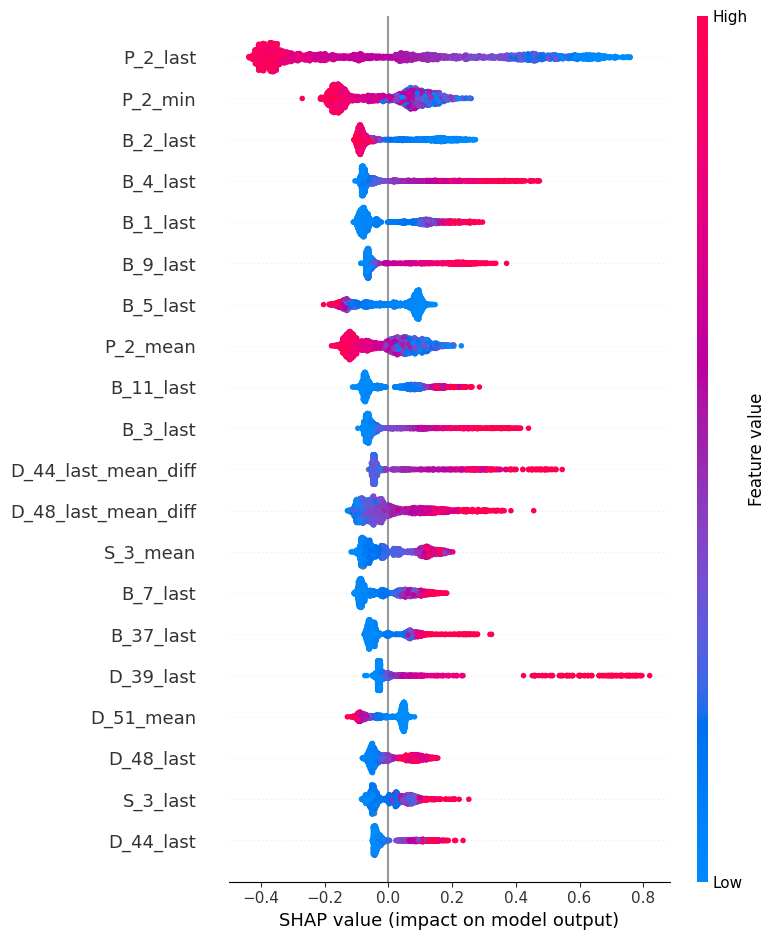

['explainer.bz2']

In [9]:
shap.initjs()
explainer = shap.TreeExplainer(loaded_model,df_agg_five_percent)
shap_values = explainer.shap_values(df_agg_five_percent)
# visualize the first prediction’s explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], df_agg_five_percent.iloc[0,:])
# summarize the effects of all the features
shap.summary_plot(shap_values, df_agg_five_percent)
#saving the explainer on the heroku
ex_filename = 'explainer.bz2' #the explainer is saved in the file, put it in the heroku
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))


In [10]:
#in app.py
ex_filename = 'explainer.bz2'
ex2 = joblib.load(filename=ex_filename) #load the explainer
#the test_data contains the example_data in demo
shap_values = ex2.shap_values(df_agg_five_percent)
#visualize the explaination of the prediction on first customer in the test dataset.
st.write(shap.force_plot(ex2.expected_value, shap_values[0,:], df_agg_five_percent.iloc[0,:], matplotlib=True), unsafe_allow_html=True)


100%|===================| 1998/2000 [06:54<00:00]        

NameError: name 'st' is not defined

In [16]:
slawa_df = pd.read_csv('/Users/sjoerddewit/Downloads/Slawa_Loev.csv')

In [17]:
slawa_df.drop(columns=['customer_ID', 'S_2'], inplace=True)

In [18]:
#in app.py
ex_filename = 'explainer.bz2'
ex2 = joblib.load(filename=ex_filename) #load the explainer
#the test_data contains the example_data in demo
shap_values = ex2.shap_values(slawa_df)
#visualize the explaination of the prediction on first customer in the test dataset.
st.write(shap.force_plot(ex2.expected_value, shap_values[0,:], slawa_df.iloc[0,:], matplotlib=True), unsafe_allow_html=True)


ValueError: could not convert string to float: 'CR'

# Kaggle submission

In [4]:
loaded_model = pickle.load(open('../pickles/cat_boost_reloaded_079', 'rb'))

In [ ]:
x_pred = loaded_model.predict_proba(test_data)[:,1]